# Football Object Detection with Tactical Map Position Estimation

In [2]:
# Import libraries
import numpy as np
import pandas as pd

import cv2
import skimage
from PIL import Image
from ultralytics import YOLO
from sklearn.metrics import mean_squared_error

import json
import yaml
import time

📹 VIDEO ANALYSIS
📁 Video Path: ./test vid.mp4
🖼️  Resolution: 1280 x 720
🎬 Total Frames: 1399
⏱️  FPS: 30.00
⏳ Duration: 46.63 seconds (0.78 minutes)


C:\Users\tazie\AppData\Local\Temp\ipykernel_26880\2592626916.py:44: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tazie\AppData\Local\Temp\ipykernel_26880\2592626916.py:45: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.savefig('eda_sample_frames.png', dpi=150, bbox_inches='tight')
C:\Users\tazie\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


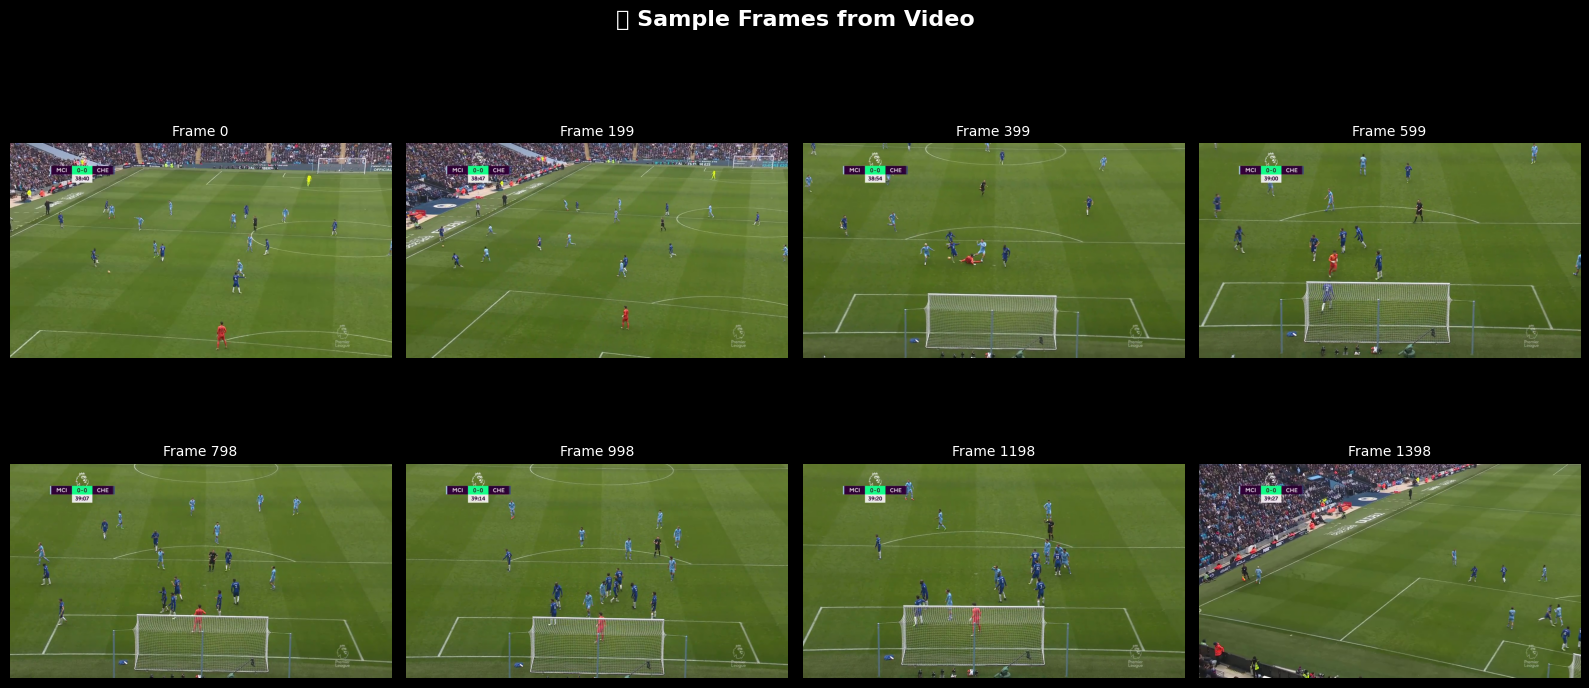

C:\Users\tazie\AppData\Local\Temp\ipykernel_26880\2592626916.py:69: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.savefig('eda_tactical_map_keypoints.png', dpi=150, bbox_inches='tight')



🗺️  TACTICAL MAP ANALYSIS
📐 Tactical Map Size: 314 x 546
🔢 Number of Keypoints: 28


C:\Users\tazie\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


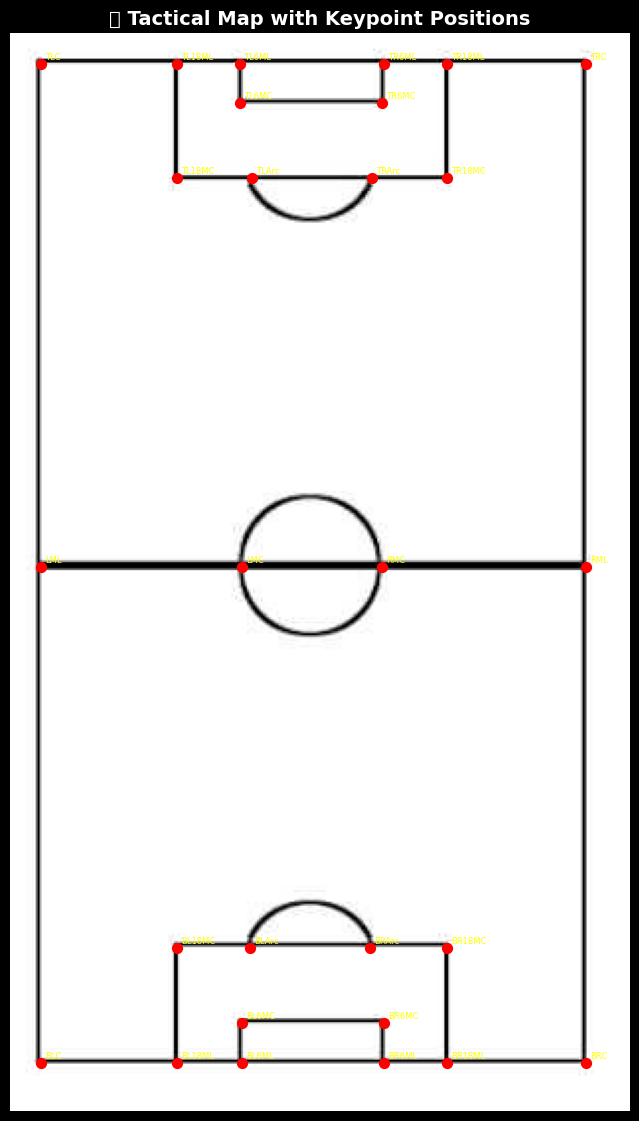


🤖 MODEL ARCHITECTURE

📊 Players Detection Model (YOLOv8L):
   - Classes: {0: 'player', 1: 'referee', 2: 'ball'}


In [30]:
# ============================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set style
plt.style.use('dark_background')
sns.set_palette("husl")

# ----- 1. Video Analysis -----
print("=" * 60)
print("📹 VIDEO ANALYSIS")
print("=" * 60)

cap_eda = cv2.VideoCapture(video_path)
total_frames = int(cap_eda.get(cv2.CAP_PROP_FRAME_COUNT))
fps_video = cap_eda.get(cv2.CAP_PROP_FPS)
width = int(cap_eda.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_eda.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration = total_frames / fps_video

print(f"📁 Video Path: {video_path}")
print(f"🖼️  Resolution: {width} x {height}")
print(f"🎬 Total Frames: {total_frames}")
print(f"⏱️  FPS: {fps_video:.2f}")
print(f"⏳ Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")

# ----- 2. Sample Frames Visualization -----
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('📸 Sample Frames from Video', fontsize=16, fontweight='bold')

sample_indices = np.linspace(0, total_frames-1, 8, dtype=int)
for idx, ax in enumerate(axes.flatten()):
    cap_eda.set(cv2.CAP_PROP_POS_FRAMES, sample_indices[idx])
    ret, frame = cap_eda.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax.imshow(frame_rgb)
        ax.set_title(f'Frame {sample_indices[idx]}', fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.savefig('eda_sample_frames.png', dpi=150, bbox_inches='tight')
plt.show()

# ----- 3. Tactical Map Analysis -----
print("\n" + "=" * 60)
print("🗺️  TACTICAL MAP ANALYSIS")
print("=" * 60)

tac_h, tac_w = tac_map.shape[:2]
print(f"📐 Tactical Map Size: {tac_w} x {tac_h}")
print(f"🔢 Number of Keypoints: {len(keypoints_map_pos)}")

# Visualize tactical map with keypoints
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
tac_map_rgb = cv2.cvtColor(tac_map, cv2.COLOR_BGR2RGB)
ax.imshow(tac_map_rgb)

for label, pos in keypoints_map_pos.items():
    ax.scatter(pos[0], pos[1], c='red', s=50, zorder=5)
    ax.annotate(label, (pos[0], pos[1]), fontsize=6, color='yellow', 
                xytext=(3, 3), textcoords='offset points')

ax.set_title('🗺️ Tactical Map with Keypoint Positions', fontsize=14, fontweight='bold')
ax.axis('off')
plt.savefig('eda_tactical_map_keypoints.png', dpi=150, bbox_inches='tight')
plt.show()

# ----- 4. Model Architecture Summary -----
print("\n" + "=" * 60)
print("🤖 MODEL ARCHITECTURE")
print("=" * 60)

print("\n📊 Players Detection Model (YOLOv8L):")
print(f"   - Classes: {labels_dic}")

In [3]:
# Get tactical map keypoints positions dictionary
json_path = "./pitch map labels position.json"
with open(json_path, 'r') as f:
    keypoints_map_pos = json.load(f)

# Get football field keypoints numerical to alphabetical mapping
yaml_path = "./config pitch dataset.yaml"
with open(yaml_path, 'r') as file:
    classes_names_dic = yaml.safe_load(file)
classes_names_dic = classes_names_dic['names']

# Get football field keypoints numerical to alphabetical mapping
yaml_path = "./config players dataset.yaml"
with open(yaml_path, 'r') as file:
    labels_dic = yaml.safe_load(file)
labels_dic = labels_dic['names']

print("Known coordinates of each keypoint on the tactical map:")
display(pd.DataFrame(keypoints_map_pos, index=['x','y']))
print("Numerical label of field keypoints (as defined when training the Yolo model):")
display(pd.Series(classes_names_dic, name='alpha_label').reset_index().rename({"index":"num_label"}, axis=1).set_index("alpha_label").transpose())
print("Numerical label of the player, referee, and ball objects (as defined when training the Yolo model):")
display(pd.Series(labels_dic, name='alpha_label').reset_index().rename({"index":"num_label"}, axis=1).set_index("alpha_label").transpose())
print('\033[1mThe dataframe representation are not used in what follows (original dictionary will be used)')

Known coordinates of each keypoint on the tactical map:


,TLC,TRC,TR6MC,TL6MC,TR6ML,TL6ML,TR18MC,TL18MC,TR18ML,TL18ML,...,BR6MC,BL6MC,BR6ML,BL6ML,BR18MC,BL18MC,BR18ML,BL18ML,BRArc,BLArc
x,15,291,188,116,189,116,221,84,221,84,...,189,117,189,117,221,84,221,84,182,121
y,15,15,35,35,15,15,73,73,15,15,...,501,501,521,521,463,463,521,521,463,463


Numerical label of field keypoints (as defined when training the Yolo model):


alpha_label,TLC,TRC,TR6MC,TL6MC,TR6ML,TL6ML,TR18MC,TL18MC,TR18ML,TL18ML,...,BR6MC,BL6MC,BR6ML,BL6ML,BR18MC,BL18MC,BR18ML,BL18ML,BRArc,BLArc
num_label,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27


Numerical label of the player, referee, and ball objects (as defined when training the Yolo model):


alpha_label,player,referee,ball
num_label,0,1,2


The dataframe representation are not used in what follows (original dictionary will be used)


In [27]:
# Set video path
video_path = './test vid.mp4'

# Read tactical map image
tac_map = cv2.imread('./tactical map.jpg')

# Define team colors (based on chosen video)
nbr_team_colors = 2
colors_dic = {
    "Chelsea":[(41,71,138), (220,98,88)], # Chelsea colors (Players kit color, GK kit color)
    "Man City":[(144,200,255), (188,199,3)] # Man City colors (Players kit color, GK kit color)
}

colors_list = colors_dic["Chelsea"]+colors_dic["Man City"] # Define color list to be used for detected player team prediction
color_list_lab = [skimage.color.rgb2lab([i/255 for i in c]) for c in colors_list] # Converting color_list to L*a*b* space

In [28]:
# Load the YOLOv8 players detection model with FP16 for faster inference
model_players = YOLO("./models/Yolo8L Players/weights/best.pt")
model_players.to('cuda')  # Ensure model is on GPU

# Load the YOLOv8 field keypoints detection model with FP16
model_keypoints = YOLO("./models/Yolo8M Field Keypoints/weights/best.pt")
model_keypoints.to('cuda')  # Ensure model is on GPU

# Precompute team colors in LAB space as numpy array for faster distance calculation
team_colors_lab = np.array([skimage.color.rgb2lab([i/255 for i in c]) for c in colors_list])

In [29]:
# Open video file
cap = cv2.VideoCapture(video_path)

# Initialize frame counter
frame_nbr = 0

# Set keypoints average displacement tolerance level (in pixels) [set to -1 to always update homography matrix]
keypoints_displacement_mean_tol = 10

# Set confidence thresholds for players and field keypoints detections
player_model_conf_thresh = 0.60
keypoints_model_conf_thresh = 0.70

# Set variable to record the time when we processed last frame 
prev_frame_time = 0
# Set variable to record the time at which we processed current frame 
new_frame_time = 0

# Store the ball track history
ball_track_history = {'src':[], 'dst':[]}

# Count consecutive frames with no ball detected
nbr_frames_no_ball = 0
nbr_frames_no_ball_thresh = 30
ball_track_dist_thresh = 100
max_track_length = 35

# ===== OPTIMIZATION: Skip keypoint detection every N frames =====
keypoint_detection_interval = 3  # Only detect keypoints every 3 frames
h = None  # Homography matrix (persistent)

# ===== OPTIMIZATION: Precompute constants =====
nbr_team_colors = 2
team_keys = list(colors_dic.keys())

# ===== MODERN UI SETTINGS =====
UI_COLORS = {
    'bg_dark': (30, 30, 35),        # Dark background
    'bg_header': (20, 20, 25),      # Header background
    'accent': (0, 200, 255),        # Cyan accent
    'accent2': (255, 100, 50),      # Orange accent
    'text_light': (255, 255, 255),  # White text
    'text_dim': (150, 150, 160),    # Dimmed text
    'success': (80, 200, 120),      # Green
    'warning': (255, 180, 50),      # Yellow/orange
}

def draw_rounded_rect(img, pt1, pt2, color, radius=10, thickness=-1, alpha=1.0):
    """Draw a rounded rectangle with optional transparency"""
    overlay = img.copy()
    x1, y1 = pt1
    x2, y2 = pt2
    
    # Draw filled rounded rectangle
    cv2.rectangle(overlay, (x1 + radius, y1), (x2 - radius, y2), color, thickness)
    cv2.rectangle(overlay, (x1, y1 + radius), (x2, y2 - radius), color, thickness)
    cv2.circle(overlay, (x1 + radius, y1 + radius), radius, color, thickness)
    cv2.circle(overlay, (x2 - radius, y1 + radius), radius, color, thickness)
    cv2.circle(overlay, (x1 + radius, y2 - radius), radius, color, thickness)
    cv2.circle(overlay, (x2 - radius, y2 - radius), radius, color, thickness)
    
    if alpha < 1.0:
        cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
    else:
        np.copyto(img, overlay)
    return img

def draw_gradient_bar(img, y_start, height, color1, color2):
    """Draw a gradient horizontal bar"""
    for i in range(height):
        alpha = i / height
        color = tuple(int(c1 * (1 - alpha) + c2 * alpha) for c1, c2 in zip(color1, color2))
        cv2.line(img, (0, y_start + i), (img.shape[1], y_start + i), color, 1)

def draw_modern_badge(img, text, pos, bg_color, text_color=(255, 255, 255), font_scale=0.5):
    """Draw a modern badge with text"""
    font = cv2.FONT_HERSHEY_SIMPLEX
    (text_w, text_h), baseline = cv2.getTextSize(text, font, font_scale, 2)
    
    x, y = pos
    padding = 8
    
    # Draw rounded background
    draw_rounded_rect(img, (x, y - text_h - padding), 
                     (x + text_w + padding * 2, y + padding), 
                     bg_color, radius=5, alpha=0.9)
    
    # Draw text
    cv2.putText(img, text, (x + padding, y), font, font_scale, text_color, 2, cv2.LINE_AA)

def draw_player_marker(img, pos, color, team_name, is_gk=False):
    """Draw a modern player marker on tactical map"""
    x, y = int(pos[0]), int(pos[1])
    
    # Outer glow
    cv2.circle(img, (x, y), 10, (*color[:3],), 2, cv2.LINE_AA)
    # Inner filled circle
    cv2.circle(img, (x, y), 6, color, -1, cv2.LINE_AA)
    # White center dot
    cv2.circle(img, (x, y), 2, (255, 255, 255), -1, cv2.LINE_AA)

def draw_fps_widget(img, fps, pos):
    """Draw a modern FPS widget"""
    x, y = pos
    
    # Background
    draw_rounded_rect(img, (x, y), (x + 100, y + 40), UI_COLORS['bg_header'], radius=8, alpha=0.85)
    
    # FPS label
    cv2.putText(img, "FPS", (x + 10, y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, UI_COLORS['text_dim'], 1, cv2.LINE_AA)
    
    # FPS value with color based on performance
    fps_color = UI_COLORS['success'] if fps > 25 else UI_COLORS['warning'] if fps > 15 else (50, 50, 255)
    cv2.putText(img, str(int(fps)), (x + 10, y + 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, fps_color, 2, cv2.LINE_AA)

def draw_modern_tactical_map(tac_map, pred_dst_pts, players_teams_list, team_keys, colors_dic, 
                              ball_pos=None, ball_track=None):
    """Create a modern styled tactical map"""
    # Create a darker styled version
    styled_map = tac_map.copy()
    
    # Add subtle grid overlay
    h, w = styled_map.shape[:2]
    
    # Draw player positions with modern markers
    for i, (pt, team_idx) in enumerate(zip(pred_dst_pts, players_teams_list)):
        if len(pt) >= 2:
            team_name = team_keys[team_idx]
            color = colors_dic[team_name][0]
            color_bgr = color[::-1]
            draw_player_marker(styled_map, pt, color_bgr, team_name)
    
    # Draw ball with glow effect
    if ball_pos is not None:
        bx, by = int(ball_pos[0]), int(ball_pos[1])
        # Glow
        cv2.circle(styled_map, (bx, by), 12, (0, 0, 150), 2, cv2.LINE_AA)
        cv2.circle(styled_map, (bx, by), 8, (0, 0, 255), -1, cv2.LINE_AA)
        cv2.circle(styled_map, (bx, by), 3, (255, 255, 255), -1, cv2.LINE_AA)
    
    # Draw ball track with gradient
    if ball_track and len(ball_track) > 1:
        points = np.array(ball_track).reshape((-1, 1, 2)).astype(np.int32)
        cv2.polylines(styled_map, [points], False, (50, 50, 200), 3, cv2.LINE_AA)
    
    return styled_map

# ===== OPTIMIZATION: Function to extract dominant color using OpenCV (faster than PIL) =====
def get_dominant_colors_fast(img_rgb, n_colors=5):
    """Fast dominant color extraction using k-means with fewer iterations"""
    if img_rgb.size == 0 or img_rgb.shape[0] < 2 or img_rgb.shape[1] < 2:
        return [[128, 128, 128]] * n_colors
    
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    if len(pixels) < n_colors:
        return [list(pixels[0])] * n_colors if len(pixels) > 0 else [[128, 128, 128]] * n_colors
    
    # Use fewer iterations for speed
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
    _, labels, centers = cv2.kmeans(pixels, min(n_colors, len(pixels)), None, criteria, 1, cv2.KMEANS_PP_CENTERS)
    
    # Count and sort by frequency
    unique, counts = np.unique(labels, return_counts=True)
    sorted_idx = np.argsort(-counts)
    
    colors = [list(centers[i].astype(int)) for i in sorted_idx[:n_colors]]
    while len(colors) < n_colors:
        colors.append(colors[-1] if colors else [128, 128, 128])
    return colors

# ===== OPTIMIZATION: Vectorized team prediction =====
def predict_teams_vectorized(palettes, team_colors_lab, nbr_team_colors):
    """Vectorized team prediction - much faster than nested loops"""
    teams = []
    for palette in palettes:
        if not palette:
            teams.append(0)
            continue
        
        # Convert palette to LAB
        palette_rgb = np.array(palette) / 255.0
        palette_lab = skimage.color.rgb2lab(palette_rgb.reshape(-1, 1, 3)).reshape(-1, 3)
        
        # Calculate distances to all team colors at once
        distances = np.linalg.norm(palette_lab[:, np.newaxis, :] - team_colors_lab[np.newaxis, :, :], axis=2)
        
        # Vote based on minimum distance
        min_team_idx = np.argmin(distances, axis=1) // nbr_team_colors
        teams.append(int(np.bincount(min_team_idx).argmax()))
    
    return teams

# ===== OPTIMIZATION: Vectorized homography transform =====
def transform_points_homography(points, h):
    """Transform multiple points using homography matrix - vectorized"""
    if len(points) == 0 or h is None:
        return np.array([])
    
    # Add homogeneous coordinate
    ones = np.ones((len(points), 1))
    pts_h = np.hstack([points, ones])
    
    # Apply homography
    transformed = pts_h @ h.T
    
    # Convert back to 2D
    transformed = transformed[:, :2] / transformed[:, 2:3]
    return transformed

# Loop through the video frames
while cap.isOpened():
    frame_nbr += 1
    success, frame = cap.read()
    
    if not success:
        break
    
    tac_map_copy = tac_map.copy()
    
    # Reset ball tracks if no ball detected for too long
    if nbr_frames_no_ball > nbr_frames_no_ball_thresh:
        ball_track_history = {'dst': [], 'src': []}

    #################### Part 1 ####################
    # Object Detection & Coordinate Transformation #
    ################################################

    # Run YOLOv8 players inference with half precision
    results_players = model_players(frame, conf=player_model_conf_thresh, half=True, verbose=False)
    
    # ===== OPTIMIZATION: Only run keypoint detection every N frames =====
    if frame_nbr % keypoint_detection_interval == 1 or h is None:
        results_keypoints = model_keypoints(frame, conf=keypoints_model_conf_thresh, half=True, verbose=False)
        
        # Cache CPU conversions (do only once)
        bboxes_k = results_keypoints[0].boxes.xyxy.cpu().numpy()
        bboxes_k_c = results_keypoints[0].boxes.xywh.cpu().numpy()
        labels_k = results_keypoints[0].boxes.cls.cpu().numpy().astype(int)
        
        detected_labels = [classes_names_dic[i] for i in labels_k]
        
        if len(detected_labels) > 3:
            detected_labels_src_pts = bboxes_k_c[:, :2].astype(int)
            detected_labels_dst_pts = np.array([keypoints_map_pos[i] for i in detected_labels])
            
            # Calculate homography
            h, _ = cv2.findHomography(detected_labels_src_pts, detected_labels_dst_pts)
            detected_labels_prev = detected_labels.copy()
            detected_labels_src_pts_prev = detected_labels_src_pts.copy()
    
    # ===== OPTIMIZATION: Cache all CPU conversions once =====
    boxes = results_players[0].boxes
    bboxes_p = boxes.xyxy.cpu().numpy()
    bboxes_p_c = boxes.xywh.cpu().numpy()
    labels_p = boxes.cls.cpu().numpy().astype(int)
    confs_p = boxes.conf.cpu().numpy()
    
    # Filter players and balls
    player_mask = labels_p == 0
    ball_mask = labels_p == 2
    
    bboxes_p_c_0 = bboxes_p_c[player_mask]
    bboxes_p_c_2 = bboxes_p_c[ball_mask]
    
    # Get player positions and transform if homography exists
    pred_dst_pts = np.array([])
    detected_ball_dst_pos = None
    detected_ball_src_pos = None
    
    if h is not None and len(bboxes_p_c_0) > 0:
        # Player feet positions (center bottom of bbox)
        detected_ppos_src_pts = bboxes_p_c_0[:, :2] + np.column_stack([
            np.zeros(len(bboxes_p_c_0)), 
            bboxes_p_c_0[:, 3] / 2
        ])
        
        # Vectorized homography transform
        pred_dst_pts = transform_points_homography(detected_ppos_src_pts, h)
        
        # Ball position
        if len(bboxes_p_c_2) > 0:
            detected_ball_src_pos = bboxes_p_c_2[0, :2]
            ball_dst = transform_points_homography(detected_ball_src_pos.reshape(1, 2), h)
            if len(ball_dst) > 0:
                detected_ball_dst_pos = ball_dst[0]
                
                # Update ball track
                if len(ball_track_history['src']) > 0:
                    last_pos = np.array(ball_track_history['src'][-1])
                    if np.linalg.norm(detected_ball_src_pos - last_pos) < ball_track_dist_thresh:
                        ball_track_history['src'].append(tuple(detected_ball_src_pos.astype(int)))
                        ball_track_history['dst'].append(tuple(detected_ball_dst_pos.astype(int)))
                    else:
                        ball_track_history = {'src': [tuple(detected_ball_src_pos.astype(int))],
                                             'dst': [tuple(detected_ball_dst_pos.astype(int))]}
                else:
                    ball_track_history['src'].append(tuple(detected_ball_src_pos.astype(int)))
                    ball_track_history['dst'].append(tuple(detected_ball_dst_pos.astype(int)))
                
                # Limit track length
                if len(ball_track_history['src']) > max_track_length:
                    ball_track_history['src'].pop(0)
                    ball_track_history['dst'].pop(0)
                
                nbr_frames_no_ball = 0
        else:
            nbr_frames_no_ball += 1

    ######### Part 2 ########## 
    # Players Team Prediction #
    ###########################

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    obj_palette_list = []
    annotated_frame = frame.copy()
    
    # ===== OPTIMIZATION: Extract colors only for players, with faster method =====
    player_indices = np.where(player_mask)[0]
    
    for idx in player_indices:
        bbox = bboxes_p[idx]
        x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        
        obj_img = frame_rgb[y1:y2, x1:x2]
        if obj_img.size == 0:
            obj_palette_list.append([[128, 128, 128]] * 5)
            continue
            
        obj_h, obj_w = obj_img.shape[:2]
        
        # Extract center region (jersey area)
        cx1 = max((obj_w // 2) - (obj_w // 5), 0)
        cx2 = (obj_w // 2) + (obj_w // 5)
        cy1 = max((obj_h // 3) - (obj_h // 5), 0)
        cy2 = (obj_h // 3) + (obj_h // 5)
        
        center_filter = obj_img[cy1:cy2, cx1:cx2]
        
        # Fast color extraction
        palette = get_dominant_colors_fast(center_filter, 5)
        obj_palette_list.append(palette)
    
    # ===== OPTIMIZATION: Vectorized team prediction =====
    players_teams_list = predict_teams_vectorized(obj_palette_list, team_colors_lab, nbr_team_colors)

    #################### Part 3 #####################
    # Modern UI - Frame & Tactical Map Annotations  #
    #################################################

    palette_box_size = 8
    j = 0
    
    for i in range(len(bboxes_p)):
        conf = confs_p[i]
        x1, y1, x2, y2 = bboxes_p[i].astype(int)
        
        if labels_p[i] == 0:  # Player
            if j < len(players_teams_list):
                team_name = team_keys[players_teams_list[j]]
                color_rgb = colors_dic[team_name][0]
                color_bgr = color_rgb[::-1]
                
                # Modern player box with glow effect
                cv2.rectangle(annotated_frame, (x1-1, y1-1), (x2+1, y2+1), (0, 0, 0), 3)  # Shadow
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color_bgr, 2)
                
                # Modern label badge
                label_text = f"{team_name}"
                (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.45, 1)
                
                # Label background
                cv2.rectangle(annotated_frame, (x1, y1 - 22), (x1 + tw + 10, y1), color_bgr, -1)
                cv2.putText(annotated_frame, label_text, (x1 + 5, y1 - 6), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1, cv2.LINE_AA)
                
                # Confidence badge (small, on the right)
                conf_text = f"{conf:.0%}"
                cv2.putText(annotated_frame, conf_text, (x2 - 35, y2 - 5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1, cv2.LINE_AA)
                
                # Color palette (vertical, modern style)
                if j < len(obj_palette_list):
                    palette = obj_palette_list[j]
                    for k, c in enumerate(palette[:3]):  # Only show top 3 colors
                        c_bgr = tuple(int(x) for x in c[::-1])
                        py = y1 + k * (palette_box_size + 2)
                        cv2.rectangle(annotated_frame, (x2 + 3, py), 
                                     (x2 + 3 + palette_box_size, py + palette_box_size), c_bgr, -1)
                        cv2.rectangle(annotated_frame, (x2 + 3, py), 
                                     (x2 + 3 + palette_box_size, py + palette_box_size), (0,0,0), 1)
            j += 1
            
        else:  # Referee or ball
            label = labels_dic[labels_p[i]]
            if labels_p[i] == 2:  # Ball
                cv2.circle(annotated_frame, ((x1+x2)//2, (y1+y2)//2), max((x2-x1)//2, 8), (0, 0, 255), 2)
                cv2.circle(annotated_frame, ((x1+x2)//2, (y1+y2)//2), 3, (255, 255, 255), -1)
            else:  # Referee
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (200, 200, 200), 2)
                cv2.putText(annotated_frame, f"REF", (x1, y1 - 6), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200, 200, 200), 1, cv2.LINE_AA)
    
    # Create modern tactical map
    styled_tac_map = draw_modern_tactical_map(
        tac_map_copy, pred_dst_pts, players_teams_list, team_keys, colors_dic,
        ball_pos=detected_ball_dst_pos, 
        ball_track=ball_track_history['dst']
    )
    
    #################### Part 4 #####################
    # Modern Final Composition                      #
    #################################################
    
    # Create dark themed borders
    header_height = 50
    footer_height = 10
    side_padding = 10
    
    # Add dark header to frame
    frame_h, frame_w = annotated_frame.shape[:2]
    final_frame = np.zeros((frame_h + header_height + footer_height, frame_w + side_padding * 2, 3), dtype=np.uint8)
    final_frame[:, :] = UI_COLORS['bg_dark'][::-1]
    
    # Place annotated frame
    final_frame[header_height:header_height + frame_h, side_padding:side_padding + frame_w] = annotated_frame
    
    # Add dark header to tactical map
    tac_h, tac_w = styled_tac_map.shape[:2]
    final_tac = np.zeros((frame_h + header_height + footer_height, tac_w + side_padding * 2, 3), dtype=np.uint8)
    final_tac[:, :] = UI_COLORS['bg_dark'][::-1]
    
    # Resize tactical map to match
    styled_tac_map_resized = cv2.resize(styled_tac_map, (tac_w, frame_h))
    final_tac[header_height:header_height + frame_h, side_padding:side_padding + tac_w] = styled_tac_map_resized
    
    # Combine both panels
    final_img = cv2.hconcat((final_frame, final_tac))
    
    # Draw gradient header
    draw_gradient_bar(final_img, 0, header_height, UI_COLORS['bg_header'], UI_COLORS['bg_dark'])
    
    # Calculate FPS
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time) if prev_frame_time > 0 else 0
    prev_frame_time = new_frame_time
    
    # Draw modern FPS widget
    draw_fps_widget(final_img, fps, (15, 8))
    
    # Title text
    cv2.putText(final_img, "FOOTBALL ANALYTICS", (150, 32), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, UI_COLORS['text_light'], 2, cv2.LINE_AA)
    
    # Team info badges
    team1, team2 = team_keys[0], team_keys[1]
    c1 = colors_dic[team1][0][::-1]
    c2 = colors_dic[team2][0][::-1]
    
    # Team 1 badge
    cv2.rectangle(final_img, (450, 12), (550, 38), c1, -1)
    cv2.putText(final_img, team1, (455, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    
    # VS text
    cv2.putText(final_img, "vs", (560, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, UI_COLORS['text_dim'], 1, cv2.LINE_AA)
    
    # Team 2 badge
    cv2.rectangle(final_img, (590, 12), (700, 38), c2, -1)
    cv2.putText(final_img, team2, (595, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    
    # Tactical map title
    tac_title_x = frame_w + side_padding * 2 + 50
    cv2.putText(final_img, "TACTICAL VIEW", (tac_title_x, 32), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, UI_COLORS['accent'], 2, cv2.LINE_AA)
    
    # Controls hint (right side)
    cv2.putText(final_img, "[P] Pause  [Q] Quit", (final_img.shape[1] - 180, 32), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, UI_COLORS['text_dim'], 1, cv2.LINE_AA)
    
    cv2.imshow("Football Analytics - AI Powered", final_img)
    
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
    if key == ord('p'):
        cv2.waitKey(-1)

cap.release()
cv2.destroyAllWindows()